### Defend Your Home Against Hurricanes Using Data Science
#### This python tool retrieves the newest forecasted water level guidance and compares it to your home's base elevation to produce a graph which allows you to easily determine if barriers are necessary.
#### The barrier height can be determined by comparing the NOAA Extratropical Water Level Guidance to your home's base elevation.
##### NOAA ETSS Beautiful Soup Retriever
##### The first step utilizes the requests library to issue an HTTP get request.
##### This will retrieve the html data and store it in python for use.

In [354]:
import requests
from bs4 import BeautifulSoup

URL = "https://slosh.nws.noaa.gov/etsurge/index.php?page=stn&region=gm&datum=msl&list=&map=0-48&type=text&stn=flpete"
page = requests.get(URL)

print(page.text)
soup = BeautifulSoup(page.content, "html.parser") 

<!DOCTYPE html>
<html lang="en" xmlns="https://www.w3.org/1999/xhtml">
<head>
  <SCRIPT LANGUAGE="JavaScript"><!-- Hide script
// End hide -->
</SCRIPT>
  <title>ETSS stn</title>
  <meta name="DC.title" content="Extra-Tropical Storm Surge">
  <meta name="DC.description" content="Extra-Tropical Storm Surge landing page">
  <meta name="DC.creator" content="NWS/Meteorological Development Lab">
  <meta name="DC.language" scheme="DCTERMS.RFC1766" content="EN-US">
  <meta name="rating" content="general">
  <meta name="resource-type" content="document">
  <meta name="distribution" content="global">
  <meta http-equiv="Window-target" content="_top">
  <meta charset="iso-8859-1">
  <base target="_self">

  <link rel="stylesheet" type="text/css" href="ss/ssMain.css">
  <meta name="Keywords" content="etsurge, extra tropical storm surge, extra-tropical storm surge, extratropcial storm surge, storm surge, SLOSH">

  <link rel="stylesheet" type="text/css" href="etsurge2.0main.css"/>
  <link rel="sty

In [355]:
# Extract the content between the <pre> tags
pre_content = soup.find('pre').get_text()

# Output the NOAA etss data table 
print(pre_content)

#Saint Petersburg, FL : 10/31/2024 01:20:21 GMT (units in feet MSL)
#Date(GMT), Surge,   Tide,    Obs,   Fcst,   Anom, Comment
#------------------------------------------------------------
10/29 06Z,   0.20,   0.81,   0.93,  99.90,  -0.08,
10/29 07Z,   0.20,   0.55,   0.58,  99.90,  -0.17,
10/29 08Z,   0.20,   0.20,   0.15,  99.90,  -0.25,
10/29 09Z,   0.10,  -0.16,  -0.23,  99.90,  -0.17,
10/29 10Z,   0.10,  -0.44,  -0.55,  99.90,  -0.21,
10/29 11Z,   0.20,  -0.57,  -0.66,  99.90,  -0.29,  (min)
10/29 12Z,   0.10,  -0.53,  -0.49,  99.90,  -0.06,
10/29 13Z,   0.20,  -0.32,  -0.18,  99.90,  -0.06,
10/29 14Z,   0.20,  -0.01,   0.20,  99.90,   0.01,
10/29 15Z,   0.20,   0.33,   0.60,  99.90,   0.07,
10/29 16Z,   0.20,   0.61,   0.96,  99.90,   0.15,
10/29 17Z,   0.20,   0.77,   1.17,  99.90,   0.20,
10/29 18Z,   0.30,   0.78,   1.19,  99.90,   0.11,  (max)
10/29 19Z,   0.30,   0.63,   1.03,  99.90,   0.10,
10/29 20Z,   0.40,   0.37,   0.81,  99.90,   0.04,
10/29 21Z,   0.40,   0.07,   0.5

### Now let's create a pandas dataframe from the data. This will allow us to calculate and plot parameters
#### All values of 99.90 have been replaced with NaN. NOAA's dataset should be examined to understand 99.90 values.


In [356]:
import pandas as pd
import numpy as np

# Split the NOAA pre_content from the ETSS website
lines = pre_content.splitlines()

# Filter out comments and empty lines (lines start with '#')
data_lines = [line for line in lines if not line.startswith('#') and line.strip()]

# Split each valid line by commas and remove extra spaces
data = [line.split(',') for line in data_lines]

# Create Pandas DataFrame from the extracted data
columns = ['Date(GMT)', 'Surge', 'Tide', 'Obs', 'Fcst', 'Anom', 'Comment']
df = pd.DataFrame(data, columns=columns)

# Apply strip to all string cells in the DataFrame
df = df.apply(lambda col: col.map(lambda x: x.strip() if isinstance(x, str) else x))

# Convert numeric columns to appropriate data types
df[['Surge', 'Tide', 'Obs', 'Fcst', 'Anom']] = df[['Surge', 'Tide', 'Obs', 'Fcst', 'Anom']].astype(float)

# Replace any value equal to 99.90 with NaN
df.replace(99.90, np.nan, inplace=True)

# Print df
print(df)

     Date(GMT)  Surge  Tide   Obs  Fcst  Anom Comment
0    10/29 06Z    0.2  0.81  0.93   NaN -0.08        
1    10/29 07Z    0.2  0.55  0.58   NaN -0.17        
2    10/29 08Z    0.2  0.20  0.15   NaN -0.25        
3    10/29 09Z    0.1 -0.16 -0.23   NaN -0.17        
4    10/29 10Z    0.1 -0.44 -0.55   NaN -0.21        
..         ...    ...   ...   ...   ...   ...     ...
128  11/03 14Z    0.6 -1.36   NaN -0.70  0.06   (min)
129  11/03 15Z    0.6 -1.26   NaN -0.61  0.06        
130  11/03 16Z    0.5 -0.99   NaN -0.43  0.06        
131  11/03 17Z    0.5 -0.61   NaN -0.05  0.06        
132  11/03 18Z    0.5 -0.21   NaN  0.34  0.06        

[133 rows x 7 columns]


### Set the Home Base Elevation to Compare with Total Water Level Guidance

In [357]:
# Set the home base elevation value (MSL ft)
home_base_elev = 6.2
#home_base_elev = 3.67

### Plot the Date(GMT) versus the Observed, Forecasted (MSL feet), and Home Base Elevations

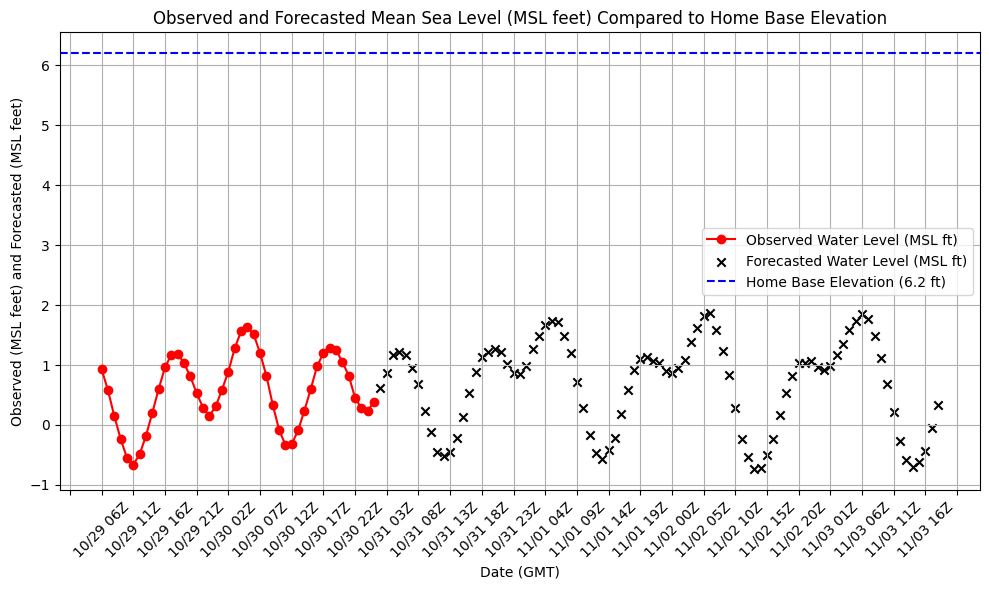

In [358]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Plot data on figure (x) vs (y)
plt.figure(figsize=(10, 6))

# X values will be 'Date(GMT)' and Y values will be 'Obs'
plt.plot(df['Date(GMT)'], df['Obs'], marker='o', linestyle='-', color='r', label='Observed Water Level (MSL ft)')
# Add Fcst values as black 'X' markers
plt.scatter(df['Date(GMT)'], df['Fcst'], color='black', marker='x', label='Forecasted Water Level (MSL ft)')
# Add a horizontal line at y = home_base_elev
plt.axhline(y=home_base_elev, color='b', linestyle='--', label=f'Home Base Elevation ({home_base_elev} ft)')

# Formatting the plot
plt.xlabel('Date (GMT)')
plt.ylabel('Observed (MSL feet) and Forecasted (MSL feet)')
plt.title('Observed and Forecasted Mean Sea Level (MSL feet) Compared to Home Base Elevation')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
# Reducing the number of dates/times on the x-axis
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=30))  # Limit to 6 x-axis labels

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# tight_layout to automatically adjust plotting parameters
plt.tight_layout()

# Save the plot as a JPEG file
plt.savefig("C:/KG_MobileFiles_2024/Python/sample_plot1.jpg", format='jpg')

# Display the plot
plt.show()


In [359]:
print(df)

     Date(GMT)  Surge  Tide   Obs  Fcst  Anom Comment
0    10/29 06Z    0.2  0.81  0.93   NaN -0.08        
1    10/29 07Z    0.2  0.55  0.58   NaN -0.17        
2    10/29 08Z    0.2  0.20  0.15   NaN -0.25        
3    10/29 09Z    0.1 -0.16 -0.23   NaN -0.17        
4    10/29 10Z    0.1 -0.44 -0.55   NaN -0.21        
..         ...    ...   ...   ...   ...   ...     ...
128  11/03 14Z    0.6 -1.36   NaN -0.70  0.06   (min)
129  11/03 15Z    0.6 -1.26   NaN -0.61  0.06        
130  11/03 16Z    0.5 -0.99   NaN -0.43  0.06        
131  11/03 17Z    0.5 -0.61   NaN -0.05  0.06        
132  11/03 18Z    0.5 -0.21   NaN  0.34  0.06        

[133 rows x 7 columns]


### We want to understand how the Observed and Forecasted data compares to the Home Base Elevation to see if the water level will exceed the Home Base Elevation. If the Water Level exceeds the Home Base Elevation then a Barrier is required. It is advised to consider barriers if the water level is within 1.25 ft (based on users judgement) of the Home Base Elevation.

In [360]:
# Add Columns Barrier_HeightObs and Barrier_HeightFcst to df
df['WaterLevel_DiffObs'] = df['Obs'] - home_base_elev
df['WaterLevel_DiffFcst'] = df['Fcst'] - home_base_elev
print(df)

     Date(GMT)  Surge  Tide   Obs  Fcst  Anom Comment  WaterLevel_DiffObs  \
0    10/29 06Z    0.2  0.81  0.93   NaN -0.08                       -5.27   
1    10/29 07Z    0.2  0.55  0.58   NaN -0.17                       -5.62   
2    10/29 08Z    0.2  0.20  0.15   NaN -0.25                       -6.05   
3    10/29 09Z    0.1 -0.16 -0.23   NaN -0.17                       -6.43   
4    10/29 10Z    0.1 -0.44 -0.55   NaN -0.21                       -6.75   
..         ...    ...   ...   ...   ...   ...     ...                 ...   
128  11/03 14Z    0.6 -1.36   NaN -0.70  0.06   (min)                 NaN   
129  11/03 15Z    0.6 -1.26   NaN -0.61  0.06                         NaN   
130  11/03 16Z    0.5 -0.99   NaN -0.43  0.06                         NaN   
131  11/03 17Z    0.5 -0.61   NaN -0.05  0.06                         NaN   
132  11/03 18Z    0.5 -0.21   NaN  0.34  0.06                         NaN   

     WaterLevel_DiffFcst  
0                    NaN  
1                    

### Add the Barrier_HeightReq column that checks if the Barrier_HeightObs or Barrier_HeightFcst are greater than zero. If the calculated number is negative, then it is marked as NaN meaning no barrier is required since the Base Home Elevation is greater than the Observed or Forecasted water height MSL.

In [361]:
# Create Barrier_Height column that checks if Barrier_HeightObs or Barrier_HeightFcst are greater than zero, if true print the positive number, if not NaN
df['Barrier_HeightMin'] = np.where(df['WaterLevel_DiffObs'] > 0, df['WaterLevel_DiffObs'],
                        np.where(df['WaterLevel_DiffFcst'] > 0, df['WaterLevel_DiffFcst'], np.nan))
print(df)

     Date(GMT)  Surge  Tide   Obs  Fcst  Anom Comment  WaterLevel_DiffObs  \
0    10/29 06Z    0.2  0.81  0.93   NaN -0.08                       -5.27   
1    10/29 07Z    0.2  0.55  0.58   NaN -0.17                       -5.62   
2    10/29 08Z    0.2  0.20  0.15   NaN -0.25                       -6.05   
3    10/29 09Z    0.1 -0.16 -0.23   NaN -0.17                       -6.43   
4    10/29 10Z    0.1 -0.44 -0.55   NaN -0.21                       -6.75   
..         ...    ...   ...   ...   ...   ...     ...                 ...   
128  11/03 14Z    0.6 -1.36   NaN -0.70  0.06   (min)                 NaN   
129  11/03 15Z    0.6 -1.26   NaN -0.61  0.06                         NaN   
130  11/03 16Z    0.5 -0.99   NaN -0.43  0.06                         NaN   
131  11/03 17Z    0.5 -0.61   NaN -0.05  0.06                         NaN   
132  11/03 18Z    0.5 -0.21   NaN  0.34  0.06                         NaN   

     WaterLevel_DiffFcst  Barrier_HeightMin  
0                    NaN     

### Determine if we need a barrier!
#### Find the Maximum Water Height Based on Observed and Current Forecast Data. The maximum water height will determine if a barrier is required for water not to exceed the home base elevation. 

In [362]:
barrierHeightReqMin = df['Barrier_HeightMin'].max()
if barrierHeightReqMin > 0:
    print('The maximum forecasted water height is:', barrierHeightReqMin, 'feet MSL')
print('No barrier is required based on observed and forecasted data.')

No barrier is required based on observed and forecasted data.


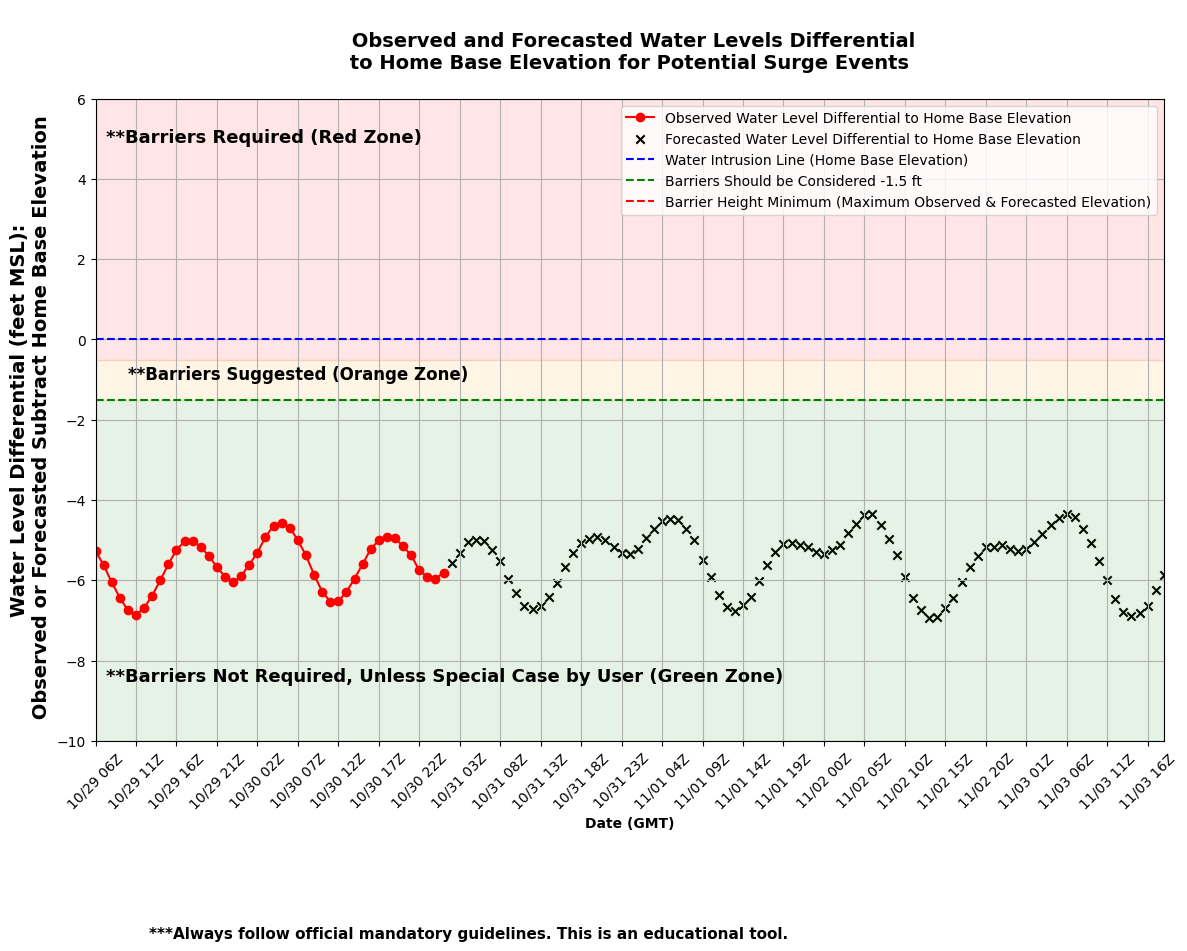

In [363]:
# Plot data on figure (x) vs (y)
plt.figure(figsize=(12, 10))

# X values will be 'Date(GMT)' and Y values will be 'Obs'
plt.plot(df['Date(GMT)'], df['WaterLevel_DiffObs'], marker='o', linestyle='-', color='r', label='Observed Water Level Differential to Home Base Elevation')
# Add Fcst values as black 'X' markers
plt.scatter(df['Date(GMT)'], df['WaterLevel_DiffFcst'], color='black', marker='x', label='Forecasted Water Level Differential to Home Base Elevation')

# Add a horizontal line at y = 0
plt.axhline(y=0, color='b', linestyle='--', label=f'Water Intrusion Line (Home Base Elevation)')
# Add a horizontal line at y = 0
plt.axhline(y=-1.5, color='g', linestyle='--', label=f'Barriers Should be Considered -1.5 ft')
# Add a horizontal line at y = 0
plt.axhline(y=barrierHeightReqMax, color='r', linestyle='--', label=f'Barrier Height Minimum (Maximum Observed & Forecasted Elevation)')

# Add fill between y = -5 and y = -1
plt.fill_between(df['Date(GMT)'], -10, -1.5, color='green', alpha=0.1)
# Add fill between y = -1 and y = 0
plt.fill_between(df['Date(GMT)'], -1.5, -0.5, color='orange', alpha=0.1)
# Add fill between y = 3 and y = 0
plt.fill_between(df['Date(GMT)'], 6, -0.5, color='red', alpha=0.1)

# Formatting the plot
plt.xlabel('Date (GMT)', fontweight='bold')
plt.ylabel('Water Level Differential (feet MSL):\n Observed or Forecasted Subtract Home Base Elevation', fontsize=14, fontweight='bold')
plt.title('\n Observed and Forecasted Water Levels Differential\n to Home Base Elevation for Potential Surge Events \n', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

# Set x-axis limits to start and end at first and last data points
plt.xlim(df['Date(GMT)'].iloc[0], df['Date(GMT)'].iloc[-1])  # Start and end at first and last points
plt.ylim(-10,6)
# Reducing the number of dates/times on the x-axis
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=30))  # Limit to 6 x-axis labels

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adding the note above the legend
plt.text(0.01, 0.94, "**Barriers Required (Red Zone)",
         ha='left', va='center', transform=plt.gca().transAxes, fontsize=13, color='black', fontweight='bold')

# Adding the text "Barrier recommended" at the fifth date (index 4)
plt.text(x=df['Date(GMT)'].iloc[25], y=-1, s="**Barriers Suggested (Orange Zone)", ha='center', fontsize=12, color='black', fontweight='bold')



# Adding the note above the legend
plt.text(0.01, 0.1, "**Barriers Not Required, Unless Special Case by User (Green Zone)",
         ha='left', va='center', transform=plt.gca().transAxes, fontsize=13, color='black', fontweight='bold')

# Adding the note bottom left
plt.text(0.05, -0.3, "***Always follow official mandatory guidelines. This is an educational tool.",
         ha='left', va='center', transform=plt.gca().transAxes, fontsize=11, color='black', fontweight='bold')

# tight_layout to automatically adjust plotting parameters
plt.tight_layout()

# Save the plot as a JPEG file
#plt.savefig("C:/KG_MobileFiles_2024/Python/sample_plot3.jpg", format='jpg')

# Display the plot
plt.show()
